# Cyber Data Analytics - Lab 1

* Konrad Ponichtera
* Ion Babalau

# Introduction

The purpose of this lab is to explore the methods of working with severely imbalanced data, which is a common situation in the cyber security field.
We will also explore the ways of protecting privacy of the users, whose data were collected, without altering the performance of the machine learning algorithms.



## Peek into the raw data

The data set, provided in the _train_data.csv_ file consists of 189628 rows with information about credit and debit card transactions.
Among these, 276 transactions are fraudulent, which means that one of the classes is represented by less than 0.1% of the entries in the data set.

In [ ]:
import re
import time
import random
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.neighbors import NearestNeighbors
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [2]:
df = pd.read_csv("data/train_data.csv")

df_benign = df.loc[df['label'] == 0]
df_fraud = df.loc[df['label'] == 1]

print(f"Number of transactions: {len(df)}")
print(f"Number of benign transactions: {len(df_benign)}")
print(f"Number of fradulent transactions: {len(df_fraud)}")
print(f"Percentage of fraudulent transactions: {len(df_fraud) / len(df) * 100}%")

df.head()

Number of transactions: 189628
Number of benign transactions: 189352
Number of fradulent transactions: 276
Percentage of fraudulent transactions: 0.14554812580420612%


,Id,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,label
0,1,GB,mccredit,546097.0,4500.0,GBP,GB,Ecommerce,True,1,UKAccount,email132571,ip123779,card250169,0
1,2,GB,mcdebit,557349.0,3395.0,GBP,GB,Ecommerce,True,1,UKAccount,email312302,ip298387,card14235,0
2,3,GB,mccredit,542011.0,3895.0,GBP,GB,Ecommerce,True,1,UKAccount,email255027,ip260053,card31944,0
3,4,GB,visadebit,465943.0,15345.0,GBP,GB,ContAuth,False,0,UKAccount,email283167,ip54851,card120871,0
4,6,GB,visadebit,475127.0,5095.0,GBP,GB,Ecommerce,True,1,UKAccount,email325263,ip203929,card208017,0


## Data preprocessing and feature engineering

In [3]:
def currency_to_eur(row):
    currency_dict = {"BGN": 1.9558, "NZD": 1.6805, "ILS": 4.0448, "RUB": 72.2099, "CAD": 1.5075, "USD": 1.1218,
                     "PHP": 58.125, "CHF": 1.1437, "ZAR": 16.0224, "AUD": 1.5911, "JPY": 124.93, "TRY": 6.6913,
                     "HKD": 8.8007, "MYR": 4.6314, "THB": 35.802, "HRK": 7.413, "NOK": 9.6678, "IDR": 15953.68,
                     "DKK": 7.4646, "CZK": 25.659, "HUF": 322.97, "GBP": 0.86248, "MXN": 21.2829, "KRW": 1308.01,
                     "ISK": 136.2, "SGD": 1.5263, "BRL": 4.405, "PLN": 4.2868, "INR": 78.0615, "RON": 4.7596,
                     "CNY": 7.5541, "SEK": 10.635}
    return row['amount'] / (currency_dict[row['currencycode']] * 100)

def process_data(df):
    # Work on copy of the original data
    df = df.copy()
    
    # Prepare card id and ip id for plotting
    
    # 1.Card ID
    card_enc = LabelEncoder()
    card_enc.fit(df['card_id'])
    df['card_id'] = card_enc.transform(df.card_id)

    # 2.IP ID
    ip_enc = LabelEncoder()
    ip_enc.fit(df['ip_id'])
    df['ip_id'] = ip_enc.transform(df.ip_id)

    # Encoding, Cleaning the data
    df.loc[df['cardverificationcodesupplied'].isna(), 'cardverificationcodesupplied'] = False
    df.loc[df['issuercountrycode'].isna(), 'issuercountrycode'] = 'ZZ'
    df.loc[df['shoppercountrycode'].isna(), 'shoppercountrycode'] = 'ZZ'

    unique_issuer_cc = df['issuercountrycode'].unique()
    unique_shopper_cc = df['shoppercountrycode'].unique()
    both = np.append(unique_issuer_cc, unique_shopper_cc)
    df_countrycodes = pd.DataFrame(both)
    unique_codes = df_countrycodes[0].unique()
    enc = LabelEncoder()
    enc.fit(unique_codes)
    df['issuercountrycode'] = enc.transform(df.issuercountrycode)
    df['shoppercountrycode'] = enc.transform(df.shoppercountrycode)
    df['amount_eur'] = df.apply(lambda x: currency_to_eur(x), axis=1)

    enc1 = LabelEncoder()
    enc1.fit(df['txvariantcode'])
    df['txvariantcode'] = enc1.transform(df.txvariantcode)

    enc2 = LabelEncoder()
    enc2.fit(df['currencycode'])
    df['currencycode'] = enc2.transform(df.currencycode)

    enc3 = LabelEncoder()
    enc3.fit(df['shopperinteraction'])
    df['shopperinteraction'] = enc3.transform(df.shopperinteraction)

    df['accountcode'] = df['accountcode'].apply(lambda x: re.sub('Account', '', x))
    df['accountcode_cc'] = 0
    df.loc[(df['accountcode'] == 'UK'), 'accountcode_cc'] = 'GB'
    df.loc[(df['accountcode'] == 'Mexico'), 'accountcode_cc'] = 'MX'
    df.loc[(df['accountcode'] == 'Sweden'), 'accountcode_cc'] = 'SE'
    df.loc[(df['accountcode'] == 'APAC'), 'accountcode_cc'] = 'APAC'

    enc4 = LabelEncoder()
    enc4.fit(df['accountcode'])
    df['accountcode'] = enc4.transform(df.accountcode)

    enc5 = LabelEncoder()
    enc5.fit(df['cardverificationcodesupplied'])
    df['cardverificationcodesupplied'] = enc5.transform(df.cardverificationcodesupplied)

    df.loc[df['mail_id'].str.contains('na', case=False), 'mail_id'] = 'email99999'

    enc6 = LabelEncoder()
    enc6.fit(df['mail_id'])
    df['mail_id'] = enc6.transform(df.mail_id)

    df.loc[df['cvcresponsecode'] > 2, 'cvcresponsecode'] = 3

    #Feature Engineering
    df['countries_equal'] = (df['shoppercountrycode'] == df['issuercountrycode'])
    df.loc[df['countries_equal'] == False, 'countries_equal'] = 0
    df.loc[df['countries_equal'] == True, 'countries_equal'] = 1

    return df[['issuercountrycode',
             'txvariantcode',
             'bin',
             'amount',
             'currencycode',
             'shoppercountrycode',
             'shopperinteraction',
             'cardverificationcodesupplied',
             'cvcresponsecode',
             'accountcode',
             'mail_id',
             'ip_id',
             'card_id',
             'amount_eur',
             'countries_equal']
    ]


X = process_data(df)
X.head()

,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,amount_eur,countries_equal
0,49,2,546097.0,4500.0,1,49,1,1,1,3,17805,12538,105460,52.175123,1
1,49,3,557349.0,3395.0,1,49,1,1,1,3,115620,107432,29882,39.363232,1
2,49,2,542011.0,3895.0,1,49,1,1,1,3,84651,87293,123743,45.160467,1
3,49,8,465943.0,15345.0,1,49,0,0,0,3,99845,147089,14712,177.917169,1
4,49,8,475127.0,5095.0,1,49,1,1,1,3,122624,56390,75841,59.073834,1


# Exploratory data analysis

TODO

# Applying machine learning to imbalanced data

Since the class of fraudulent transactions is represented by less than 0.1% of the entries in the data set, it makes the data unsuitable for majority of available classification methods, which require even distribution of the classes.

We split the preprocessed data set into train and test sets (80/20 ratio) and try three classification methods:
* logistic regression
* random forest
* decision tree

In [52]:
y = df['label']

X_original_train, X_original_test, y_original_train, y_original_test = train_test_split(X, y, test_size=0.20, random_state=0)

print(f"Benign cases in train set: {len(y_original_train[y_original_train == 0])}")
print(f"Benign cases in test set: {len(y_original_test[y_original_test == 0])}")
print(f"Fraudulent cases in train set: {len(y_original_train[y_original_train == 1])}")
print(f"Fraudulent cases in test set: {len(y_original_test[y_original_test == 1])}")

Benign cases in train set: 151485
Benign cases in test set: 37867
Fraudulent cases in train set: 217
Fraudulent cases in test set: 59


## Logistic regression

We run the logistic regression classifier with default settings from the `scikit-learn` library.

After testing classifier's performance we immediately see that all the transactions in the test set were classified as benign.
Although there were no false positives (benign transactions classified as fraudulent), there weren't any true positives either. This makes the classifier useless in its current form.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37867
           1       0.00      0.00      0.00        59

    accuracy                           1.00     37926
   macro avg       0.50      0.50      0.50     37926
weighted avg       1.00      1.00      1.00     37926

Accuracy: 99.84443389759005


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


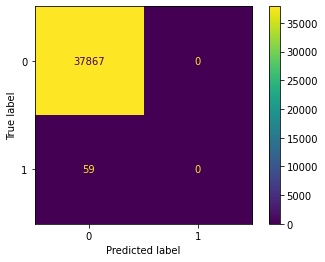

In [53]:
logreg_classifier = LogisticRegression(random_state=0, n_jobs=-1)
logreg_classifier.fit(X_original_train, y_original_train)

y_predictions = logreg_classifier.predict(X_original_test)

print(classification_report(y_original_test, y_predictions))
print(f"Accuracy: {accuracy_score(y_original_test, y_predictions) * 100}")

ConfusionMatrixDisplay.from_predictions(y_original_test, y_predictions)
plt.show()

## Random forest

We run the random forest classifier with default settings from the `scikit-learn`, with unrestricted maximum depth of the individual tree.

The classifier managed to detect 3 fraudulent transactions, without any false positives (precision of 100%). 
However, since there were 59 fraudulent transactions in the data set in general, it means that it's not very effective in determining the fraudulent transactions (recall of 5%).

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37867
           1       1.00      0.05      0.10        59

    accuracy                           1.00     37926
   macro avg       1.00      0.53      0.55     37926
weighted avg       1.00      1.00      1.00     37926

Accuracy: 99.85234403839056


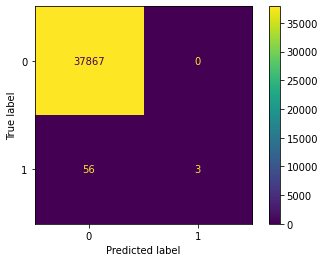

In [50]:
forest_classifier = RandomForestClassifier(random_state=0, n_jobs=-1)
forest_classifier.fit(X_original_train, y_original_train)

y_predictions = forest_classifier.predict(X_original_test)

print(classification_report(y_original_test, y_predictions))
print(f"Accuracy: {accuracy_score(y_original_test, y_predictions) * 100}")

ConfusionMatrixDisplay.from_predictions(y_original_test, y_predictions)
plt.show()

## Decision tree

Finally, we executed decision tree classifier with default settings from the `scikit-learn` library and the maximum depth of the tree set to 5 (`max_depth=5`).

Almost all the transactions were classified as benign once again, except of one benign transaction that was classified as fraudulent (false positive).

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37867
           1       0.00      0.00      0.00        59

    accuracy                           1.00     37926
   macro avg       0.50      0.50      0.50     37926
weighted avg       1.00      1.00      1.00     37926

Accuracy: 99.84179718398988


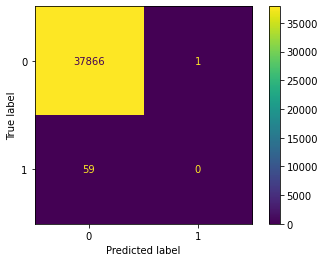

In [51]:
dtree_classifier = DecisionTreeClassifier(max_depth=5, random_state=0)
dtree_classifier.fit(X_original_train, y_original_train)

y_predictions = dtree_classifier.predict(X_original_test)

print(classification_report(y_original_test, y_predictions))
print(f"Accuracy: {accuracy_score(y_original_test, y_predictions) * 100}")

ConfusionMatrixDisplay.from_predictions(y_original_test, y_predictions)
plt.show()

## Conclusions

Although the accuracy approaching 100% would be a good sign if classes were evenly distributed, in our case it's misleading since 99.9% of the data set consists of entities of benign, while merely 0.1% is the remaining class of fraud transactions.
This leads to the classifiers becoming biased towards classifying almost all the transactions as benign ones.

This means that without additional tweaking and data set modifications, the aforementioned classification methods are not applicable for determining fraud in practice.

# Handling imbalanced data with SMOTE

_Author: Konrad Ponichtera_

One of the methods of dealing with imbalanced data sets is to perform oversampling, which generates new sythetic individuals of the minority class in a hope to increase the classification performance.
One of these methods is Synthetic Minority Oversampling Technique (SMOTE), which finds $k$-nearest minority neighbors of each individual from the minority class and generates $N$ procent new ones by drawing a (hyper)line between the individual and its random neighbor (from the $k$ nearest ones) and then randomly selecting a point on that line.

In the example below we split the original preprocessed data set into test and training sets, with respectively 217 and 59 fraudulent transactions.
Then we use SMOTE implementation to synthesize 43400 fraudulent transactions for each of 217 real ones in the training data set.
In the end, the training set consists of 151485 benign and 43617 fraudulent transactions, which should have a positive impact on classification.

**Although it would be possible to balance the data set entirely by settingSince the parameter `N=69808` of `smote` function, it was ran with `N=20000` due to already long execution time.**

After looking into the SMOTEd training data set, we see that the newly created data do not necessarily make much sense on their own - for example, the class labels are now floating point numbers instead of integers.
However, this is not an issue, since the syntheisized data is not meant to be used independently and was created purely for the purpose of being fed into the classifier.

## Generating synthetic samples

In [56]:
# Ignoring the FutureWarning which is internally thrown by NearestNeighbors
warnings.simplefilter(action='ignore', category=FutureWarning)


def smote(X, N=100, k=5, random_state=None):
    if random_state is not None:
        rng = random.Random(random_state)
    else:
        rng = random.Random()

    assert N >= 100
    N = N // 100
    
    column_names = X.columns
    new_samples = pd.DataFrame(columns=column_names)
    X = X.to_numpy()

    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(X)

    for x in X:
        nnarray = knn.kneighbors([x], k, return_distance=False)[0]
        
        # Populate
        for _ in range(N):
            nn = rng.randrange(0, k)
            
            neighbor_item = X[nnarray[nn]]
            
            diff = neighbor_item - x
            gap = rng.uniform(0, 1)
            new_item = x + gap * diff
            
            new_samples = pd.concat([new_samples, pd.DataFrame(new_item.reshape(1, -1), columns=column_names)])
        
    return new_samples


y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(f"Benign cases in train set: {len(y_train[y_train == 0])}")
print(f"Benign cases in test set: {len(y_test[y_test == 0])}")
print(f"Fraudulent cases in train set: {len(y_train[y_train == 1])}")
print(f"Fraudulent cases in test set: {len(y_test[y_test == 1])}")

X_train_fraud = X_train.loc[y_train == 1]

print(f"Starting SMOTE run for {len(X_train_fraud)} samples")
start = time.time()
X_fraud_smote = smote(X_train_fraud.copy(), N=20000, random_state=0)
smote_time = time.time() - start

print(f"SMOTE ran for {smote_time} seconds and generated {len(X_fraud_smote)} synthetic samples")

X_train = pd.concat([X_train, X_fraud_smote])
y_train = pd.concat([
    y_train,
    pd.Series(1, index=range(len(X_fraud_smote)))
])

X_train, y_train = shuffle(X_train, y_train, random_state=0)

print(f"Benign cases in train set after SMOTE: {len(y_train[y_train == 0])}")
print(f"Fraudulent cases in train set after SMOTE: {len(y_train[y_train == 1])}")

X_fraud_smote.head()

Benign cases in train set: 151485
Benign cases in test set: 37867
Fraudulent cases in train set: 217
Fraudulent cases in test set: 59
Starting SMOTE run for 217 samples



KeyboardInterrupt



# Applying machine learning to synthetic data

## Logistic regression

We create the logistic regression classifier with the same configuration as before and use the SMOTEd data set to train it.

Unlike previously, this time the classifier managed to correctly detect over 50% of the fraudulent transactions (recall of 53%).
However, its precision of 3% is very low and 1369 benign transactions were incorrectly classified as fraudulent.


              precision    recall  f1-score   support

           0       1.00      0.96      0.98     37867
           1       0.02      0.53      0.04        59

    accuracy                           0.96     37926
   macro avg       0.51      0.74      0.51     37926
weighted avg       1.00      0.96      0.98     37926

Accuracy: 96.31651110056426


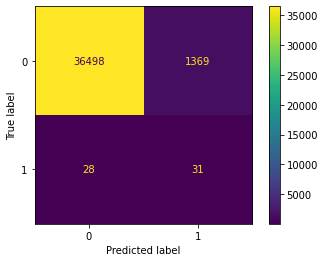

In [9]:
logreg_classifier = LogisticRegression(random_state=0, n_jobs=-1)
logreg_classifier.fit(X_train, y_train)

y_predictions = logreg_classifier.predict(X_test)
y_predictions_proba = logreg_classifier.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_predictions))
print(f"Accuracy: {accuracy_score(y_test, y_predictions) * 100}")

y_score = logreg_classifier.decision_function(X_test)

logreg_fpr, logreg_tpr, _ = roc_curve(y_test, y_predictions_proba)
logreg_roc_auc = auc(logreg_fpr, logreg_tpr)

ConfusionMatrixDisplay.from_predictions(y_test, y_predictions)
plt.show()

## Random forest

The random forest classifier was created and configured like previously, with unrestricted maximum depth of the individual tree.

The classifier managed to correctly detect only 13 out of 59 fraudulent transactions (recall of 22%).
This means that its sensitivity is much smaller than the one of logistic regression.
However, it is also much more precise (precision of 15%), which resulted in significantly smaller amount of benign transactions being marked as fraudulent (false positives)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37867
           1       0.15      0.22      0.18        59

    accuracy                           1.00     37926
   macro avg       0.58      0.61      0.59     37926
weighted avg       1.00      1.00      1.00     37926

Accuracy: 99.69150450878026


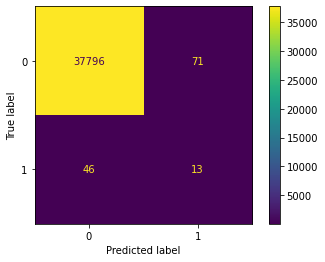

In [49]:
forest_classifier = RandomForestClassifier(random_state=0, n_jobs=-1)
forest_classifier.fit(X_train, y_train)

y_predictions = forest_classifier.predict(X_test)
y_predictions_proba = forest_classifier.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_predictions))
print(f"Accuracy: {accuracy_score(y_test, y_predictions) * 100}")

forest_fpr, forest_tpr, _ = roc_curve(y_test, y_predictions_proba)
forest_roc_auc = auc(forest_fpr, forest_tpr)

ConfusionMatrixDisplay.from_predictions(y_test, y_predictions)
plt.show()

## Decision tree

The decision tree classifier was configured to have the maximum depth of a tree set to 5.

It managed to detect much more fraudulent transactions than logistic regression and random forest - 45 out of 59 (recall of 76%).
However, it also has the lowest precision (1%) is the lowest and resulted in the highest amount of false positives. 

              precision    recall  f1-score   support

           0       1.00      0.92      0.96     37867
           1       0.01      0.76      0.03        59

    accuracy                           0.92     37926
   macro avg       0.51      0.84      0.49     37926
weighted avg       1.00      0.92      0.95     37926

Accuracy: 91.6468913146654


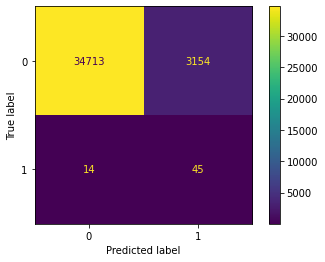

In [54]:
dtree_classifier = DecisionTreeClassifier(max_depth=5, random_state=0)
dtree_classifier.fit(X_train, y_train)

y_predictions = dtree_classifier.predict(X_test)
y_predictions_prob = dtree_classifier.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_predictions))
print(f"Accuracy: {accuracy_score(y_test, y_predictions) * 100}")

dtree_fpr, dtree_tpr, _ = roc_curve(y_test, y_predictions_prob)
dtree_roc_auc = auc(dtree_fpr, dtree_tpr)

ConfusionMatrixDisplay.from_predictions(y_test, y_predictions)
plt.show()

## Comparison

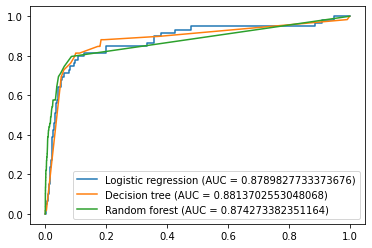

In [55]:
plt.figure(0).clf()
plt.plot(logreg_fpr, logreg_tpr, label=f"Logistic regression (AUC = {logreg_roc_auc})")
plt.plot(dtree_fpr, dtree_tpr, label=f"Decision tree (AUC = {dtree_roc_auc})")
plt.plot(forest_fpr, forest_tpr, label=f"Random forest (AUC = {forest_roc_auc})")
plt.legend()
plt.show()

## Conclusions

Although all of the used machine learning methods performed poorly when used with the original data set, using SMOTE to generate synthetic instances of the minority class resulted in increased sensitivity (recall) of the classifiers when detecting frauds.
This means that the classifiers were able to correctly classify 

However, it also led to drastic increase of false positive count, where benign transactions are classified as fraudulent.
This is not beneficial from the business point of view - if the classifiers trained above were to be used in the production system, for each blocked fraudulent transaction, few dozen of benign ones would end up blocked as well and would require manual intervention (and potentially explaination to the customer on why their transaction was blocked).

From this point of view, the random forest classifier seems to be the most suitable for the production use. 
Its sensitivity is lower than the sensitivity of logistic regression and decision tree classifiers, which means that it detects less actual fraud transactions.
However, the relatively high precision makes it feasible for the human experts to look into the detected frauds and determine which ones were indeed fraudulent.

Although the presented results are far from ideal, it is clear that SMOTE increased the overall preformance of all the tested classifiers and therefore presents a good starting point for dealing with imbalanced data.
However, the original SMOTE implementation synthesizes data, which might be potentially close to the benign individuals in the feature hyperspace.
It might be necessary to apply some extra cleaning procedure to the synthesized individuals, for example by using Tomek links.

# Classification

## Oversampling with SMOTE

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

print(f"Benign cases in train set: {len(y_train[y_train == 0])}")
print(f"Benign cases in test set: {len(y_test[y_test == 0])}")
print(f"Fraudulent cases in train set: {len(y_train[y_train == 1])}")
print(f"Fraudulent cases in test set: {len(y_test[y_test == 1])}")

smote = SMOTE(random_state=0, sampling_strategy='minority')
X_train, y_train = smote.fit_resample(X_train, y_train)

print(f"Benign cases in train set after SMOTE: {len(y_train[y_train == 0])}")
print(f"Fraudulent cases in train set after SMOTE: {len(y_train[y_train == 1])}")

Benign cases in train set: 151485
Benign cases in test set: 37867
Fraudulent cases in train set: 217
Fraudulent cases in test set: 59
Benign cases in train set after SMOTE: 151485
Fraudulent cases in train set after SMOTE: 151485


## K-fold cross validation

In [14]:
def k_fold_validation(X, y, model, scoring='precision', fold_count=10):
    cv = KFold(n_splits=fold_count, random_state=0, shuffle=True)
    scores = cross_validate(model, X, y, scoring=scoring, return_estimator=True, cv=cv, n_jobs=-1)
    max_score_index = np.argmax(scores['test_score'])
    
    return scores['estimator'][max_score_index]

## Whitebox classifier - decision tree

The decision tree classifier was chosen as a whitebox classifier, since the final tree can be easily visualized.
What's more, it is possible to follow the paths in a tree to determine the decisions, made by the classifier when classifying each individual.

The maximum depth of a tree was set to 2 (`max_depth=2`).
This will have a negative impact on the classifier performance, but will also make the tree much more readable.

              precision    recall  f1-score   support

           0       1.00      0.91      0.95     37867
           1       0.01      0.80      0.03        59

    accuracy                           0.91     37926
   macro avg       0.51      0.85      0.49     37926
weighted avg       1.00      0.91      0.95     37926

Accuracy: 91.10372831303064


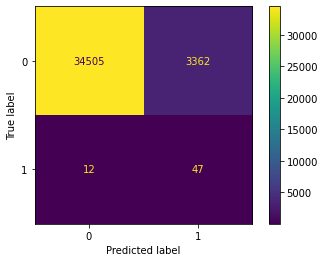

In [15]:
dtree_classifier = DecisionTreeClassifier(max_depth=2, random_state=0)
dtree_classifier = k_fold_validation(X_train, y_train, dtree_classifier)

y_predictions = dtree_classifier.predict(X_test)
y_predictions_proba = dtree_classifier.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_predictions))
print(f"Accuracy: {accuracy_score(y_test, y_predictions) * 100}")

dtree_fpr, dtree_tpr, _ = roc_curve(y_test, y_predictions_proba)
dtree_roc_auc = auc(dtree_fpr, dtree_tpr)

ConfusionMatrixDisplay.from_predictions(y_test, y_predictions)
plt.show()

### Explaining the whitebox classifier

From looking at the tree we can determine that it performs step by step filtering of the data based on different features.

Looking at one of the transactions that was classified as fraud, we can determine the decision path in the tree and thus determine how it ended up being detercted.


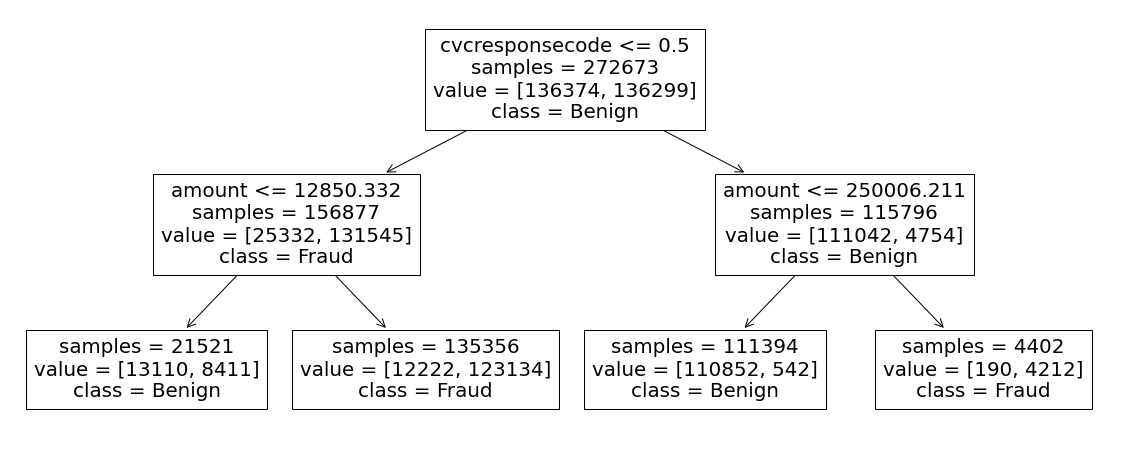

Example transaction, classified as fraud:
issuercountrycode                       49
txvariantcode                            3
bin                               532916.0
amount                             38614.0
currencycode                             1
shoppercountrycode                      49
shopperinteraction                       1
cardverificationcodesupplied             0
cvcresponsecode                          1
accountcode                              3
mail_id                              36936
ip_id                                14117
card_id                             106840
amount_eur                      447.708932
countries_equal                          1
predicted_label                          0
Name: 71148, dtype: object


In [16]:
plt.figure(figsize=(20, 8))
plot_tree(dtree_classifier, feature_names=X_train.columns, class_names=['Benign', 'Fraud'], impurity=False)
plt.show()

X_test_withpredictions = X_test.copy()
X_test_withpredictions['predicted_label'] = y_predictions
X_test_withpredictions.query('predicted_label==1')
predicted_fraud = X_test_withpredictions.iloc[0]

print("Example transaction, classified as fraud:")
print(predicted_fraud)

## Blackbox classifier - AdaBoost

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37867
           1       0.20      0.15      0.17        59

    accuracy                           1.00     37926
   macro avg       0.60      0.58      0.59     37926
weighted avg       1.00      1.00      1.00     37926

Accuracy: 99.77324263038548


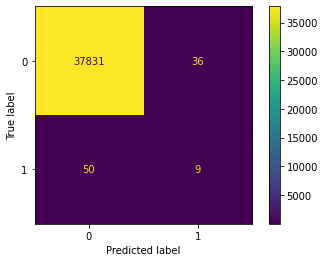

In [17]:
from sklearn.ensemble import AdaBoostClassifier

forest_classifier = RandomForestClassifier(random_state=0, n_jobs=-1, n_estimators=10)

adaboost_classifier = AdaBoostClassifier(base_estimator=forest_classifier, random_state=0, n_estimators=20)
adaboost_classifier = k_fold_validation(X_train, y_train, adaboost_classifier)

y_predictions = adaboost_classifier.predict(X_test)
y_predictions_proba = adaboost_classifier.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_predictions))
print(f"Accuracy: {accuracy_score(y_test, y_predictions) * 100}")

adaboost_fpr, adaboost_tpr, _ = roc_curve(y_test, y_predictions_proba)
adaboost_roc_auc = auc(adaboost_fpr, adaboost_tpr)

ConfusionMatrixDisplay.from_predictions(y_test, y_predictions)
plt.show()

## Comparison

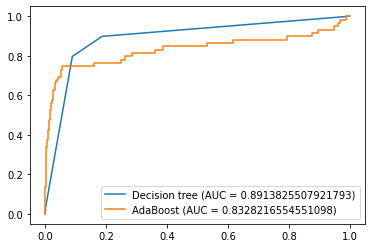

In [18]:
plt.figure(0).clf()
plt.plot(dtree_fpr, dtree_tpr, label=f"Decision tree (AUC = {dtree_roc_auc})")
plt.plot(adaboost_fpr, adaboost_tpr, label=f"AdaBoost (AUC = {adaboost_roc_auc})")
plt.legend()
plt.show()

## Using best classifier for Kaggle competition

In [19]:
df_kaggle = pd.read_csv("data/test_data.csv")
df_kaggle_processed = process_data(df_kaggle)

clf = adaboost_classifier

y_predictions = clf.predict_proba(df_kaggle_processed)

df_submission = pd.DataFrame({'Id': df_kaggle['Id'], 'Predicted': y_predictions[:, 1]})
df_submission.to_csv("submission.csv", index=False)